# Sonoran Desert: ERA5
#### Discharge in 2000
Simulation of the discharge of the Gila River in 2024, using the historical data of ERA5. The camel that is used for this notebook is: hysets_09488650

In [1]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

import matplotlib.pyplot as plt
from cartopy import crs
from cartopy import feature as cfeature
import fiona
import shapely.geometry
from pyproj import Geod
from rich import print
import pandas as pd
import xarray as xr

import ewatercycle.forcing
import ewatercycle.models
import ewatercycle.parameter_sets

### Setting up the model ERA5
Creating the parameter dataset and the forcing dataset at the Gila River, near Yuma. Next, these datasets are used to set up the pcrglobwb model.

In [2]:
station_latitude = 32.71555556
station_longitude = -114.533386

In [3]:
parameter_set = ewatercycle.parameter_sets.ParameterSet(
    name="custom_parameter_set",
    directory= "/data/shared/parameter-sets/pcrglobwb_global",
    config="./pcrglobwb_sonoran_ERA5_05min.ini",
    target_model="pcrglobwb",
    supported_model_versions={"setters"},
)

In [4]:
forcing = ewatercycle.forcing.sources["PCRGlobWBForcing"].load(
    directory="/home/emol/forcing/sonoran_desert/work/diagnostic/script",
)

In [5]:
pcrglob = ewatercycle.models.PCRGlobWB(
    parameter_set=parameter_set,
    forcing=forcing
)

In [6]:
cfg_file, cfg_dir = pcrglob.setup(
    start_time="2000-01-31T00:00:00Z",
    end_time="2000-12-31T00:00:00Z",
    max_spinups_in_years=0
)
cfg_file, cfg_dir

('/home/emol/repos/projects/book/thesis_projects/BSc/2024_Q2_ElineMol_CEG/Deliverables/pcrglobwb_20250108_192734/pcrglobwb_ewatercycle.ini',
 '/home/emol/repos/projects/book/thesis_projects/BSc/2024_Q2_ElineMol_CEG/Deliverables/pcrglobwb_20250108_192734')

In [7]:
pcrglob.initialize(cfg_file)

In [8]:
time = pd.date_range(pcrglob.start_time_as_isostr, pcrglob.end_time_as_isostr)
timeseries = pd.DataFrame(
    index=pd.Index(time, name="time"), columns=["PCRGlobWB: Sonoran Desert"]
)

recharge = pd.DataFrame(
    index=pd.Index(time, name="time"), columns=["PCRGlobWB: Sonoran Desert"]
)

In [9]:
while pcrglob.time < pcrglob.end_time:
    pcrglob.update()

    precipitation_at_station = pcrglob.get_value_at_coords(
        "precipitation", lat=[station_latitude], lon=[station_longitude]
    )

    landsurface_at_station = pcrglob.get_value_at_coords(
        "land_surface_runoff", lat=[station_latitude], lon=[station_longitude]
    )
    
    evaporation_at_station = pcrglob.get_value_at_coords(
        "total_evaporation", lat=[station_latitude], lon=[station_longitude]
    )
   
    recharge_at_station = pcrglob.get_value_at_coords(
        "groundwater_recharge", lat=[station_latitude], lon=[station_longitude]
    )
    
    time = pcrglob.time_as_isostr
    timeseries["PCRGlobWB: Sonoran Desert"][time] = precipitation_at_station[0] + landsurface_at_station[0] - evaporation_at_station[0] 
    recharge["PCRGlobWB: Sonoran Desert"][time] = recharge_at_station[0]
    # Show progress
    #print(time,end='\r')  # "\r" clears the output before printing the next timestamp


Now, the data can simulate a map that shows the discharge in the Sonoran Desert. This is also creates a graph for the year ...

In [10]:
da = pcrglob.get_value_as_xarray("discharge")

In [ ]:
fig = plt.figure(dpi=120)
ax = fig.add_subplot(111, projection=crs.PlateCarree())
da.plot(ax=ax, cmap="GnBu")

# Overlay ocean and coastines
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.RIVERS, color="k")
ax.coastlines()

# Add a red cross marker at the location of the Leven River at Newby Bridge
ax.scatter(station_longitude, station_latitude, s=250, c="r", marker="x", lw=2)

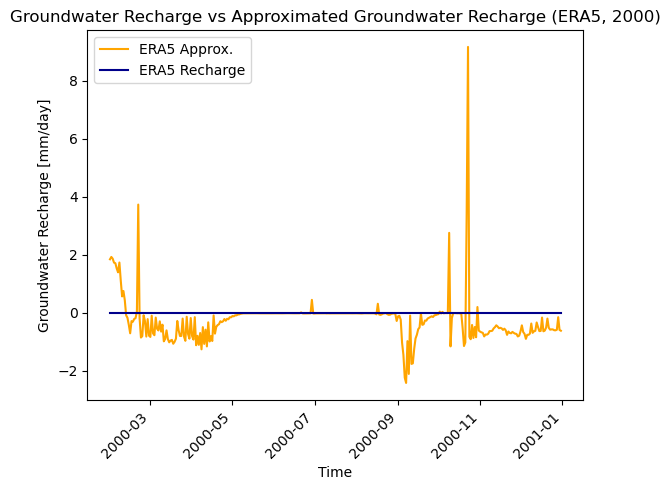

In [14]:
plt.plot(timeseries*1000, label="ERA5 Approx.", color="orange")
plt.plot(recharge*1000, label="ERA5 Recharge", color="darkblue")
#plt.axhline(y=0.0567, color="red", linestyle="--", label="Threshold")
plt.title("Groundwater Recharge vs Approximated Groundwater Recharge (ERA5, 2000)")
plt.xlabel("Time")
plt.ylabel("Groundwater Recharge [mm/day]")
plt.xticks(rotation=45, ha='right')
plt.legend();

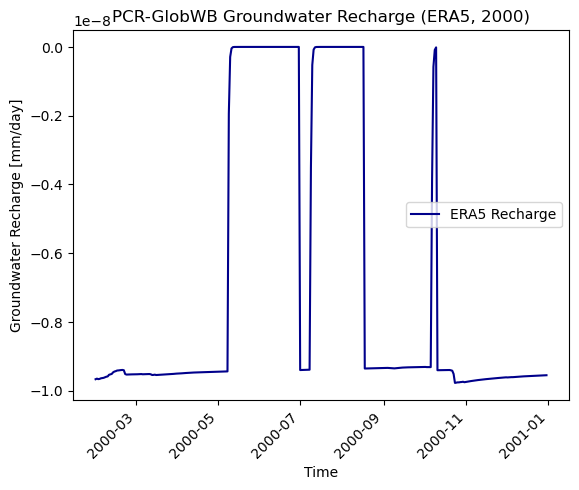

In [15]:
plt.plot(recharge*1000, label="ERA5 Recharge", color="darkblue")
plt.title("PCR-GlobWB Groundwater Recharge (ERA5, 2000)")
plt.xlabel("Time")
plt.ylabel("Groundwater Recharge [mm/day]")
plt.xticks(rotation=45, ha='right')
plt.legend();

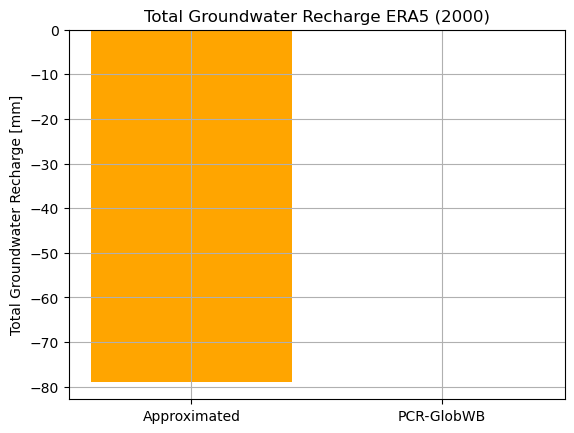

In [13]:
a = timeseries.sum() * 1000 
b = recharge.sum() * 1000 

categories = ["Approximated", "PCR-GlobWB"]
totals = [a, b]
colors = ["orange", "darkblue"]

for i in range(len(totals)):
    plt.bar(categories[i], totals[i], color=colors[i])

plt.title("Total Groundwater Recharge ERA5 (2000)")
plt.ylabel("Total Groundwater Recharge [mm]")
plt.grid()

In [ ]:
pcrglob.finalize()